## はじめに
先日、Kaggleのタイタニック問題に挑んで惨憺たる結果を出しました。
- [Kaggle のタイタニック問題に Keras で挑戦した。前処理が課題だと分かった。 | Futurismo](http://futurismo.biz/archives/6296)

データ分析をするスキルが自分にはない。なんとか身につけたいと思っていたところ、
Udemyの講座でKaggleのタイタニック問題を元にデータ分析を行っている講座を発見した。

- [【世界で5万人が受講】実践 Python データサイエンス | Udemy](https://www.udemy.com/python-jp/learn/v4/)

これはいい。まずは、講義にしたがってデータ分析してみたので、これはその講義メモです。

## 目的
以下について、講義では調べている。

+ タイタニック号の乗客はどのような人達だったのか？
+ それぞれの乗客はどのデッキにいたか？また、それは客室の種類とどのような関係にあったか？
+ 乗客は主にどこから来たのか？
+ 家族連れか、単身者か？

## SetUp
タイタニック号のデータは下記のURLのtrainからダウンロードできる。
* https://www.kaggle.com/c/titanic/data?train.csv

まずは，csvの中身を確認。カラムの意味は [kaggleのサイト](https://www.kaggle.com/c/titanic/data) を参照。

In [3]:
import pandas as pd
from pandas import Series, DataFrame
titanic_df = pd.read_csv('train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


train.csvのなかには、891人の乗客のデータが含まれるけれども、AgeやCabinが Nanが多いことがわかる。

## タイタニック号の乗客はどのような人達だったのか

性別に関して、女性、男性の数を調べる。

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

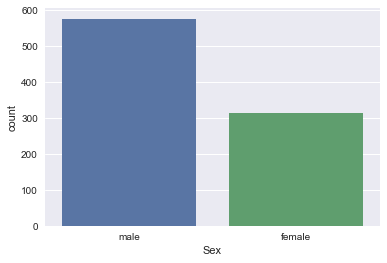

In [6]:
sns.countplot('Sex', data=titanic_df)

女性の二倍近く男性が多いことがわかる。

### 客室のクラスで層別化

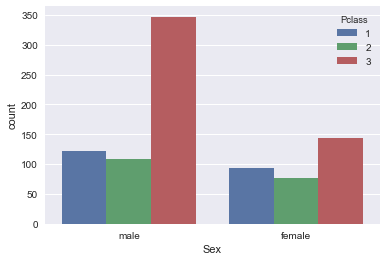

In [7]:
sns.countplot('Sex', data=titanic_df, hue='Pclass')

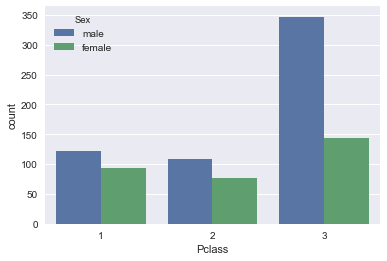

In [8]:
sns.countplot('Pclass',data=titanic_df,hue='Sex')

三等客室の男性が多いことがわかる。

### 子供という新しい列を追加
子供を優先して助けたということがkaggleのサイトにかかれているので、子供がどのくらいいるかを調べる。ここでは、16歳未満が子供。

In [9]:
def male_female_child(passenger):
    age,sex = passenger
    if age < 16:
        return 'child'
    else:
        return sex
titanic_df['person'] = titanic_df[['Age','Sex']].apply(male_female_child,axis=1)

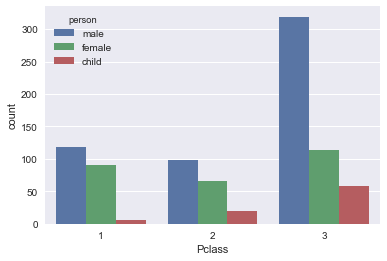

In [12]:
sns.countplot('Pclass',data=titanic_df,hue='person')

In [13]:
titanic_df['person'].value_counts()

male      537
female    271
child      83
Name: person, dtype: int64

1等客室、2客室には子供が少ない。3客室に多い。これで年齢分布が分かった。

次に、カーネル密度推定で分布を見てみる。

/home/tsu-nera/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


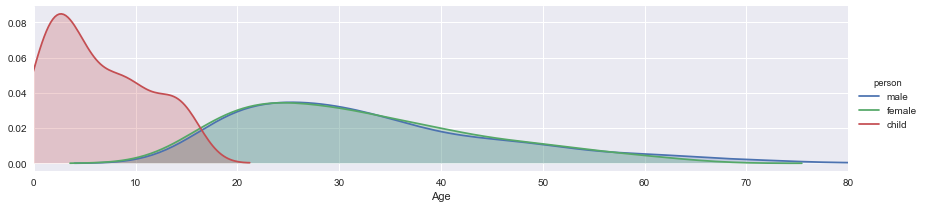

In [17]:
fig = sns.FacetGrid(titanic_df, hue="person", aspect=4)
fig.map(sns.kdeplot, 'Age', shade=True)
oldest = titanic_df['Age'].max()
fig.set(xlim=(0, oldest))
fig.add_legend()

/home/tsu-nera/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


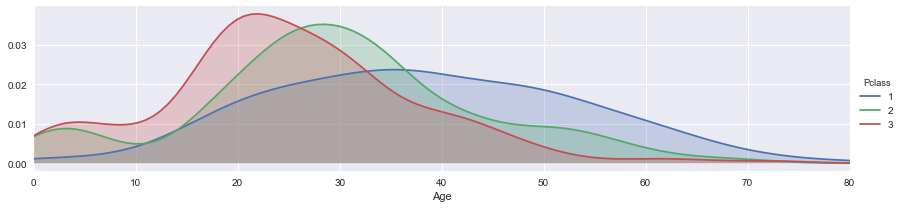

In [18]:
fig = sns.FacetGrid(titanic_df, hue="Pclass",aspect=4)
fig.map(sns.kdeplot,'Age',shade= True)
oldest = titanic_df['Age'].max()
fig.set(xlim=(0,oldest))
fig.add_legend()

## それぞれの乗客はどのデッキにいたか(Cabin)？
Cabinは Nanが多いので、これを取り除く。Cabinは頭文字(Cxx, Dxx, Exx など）でレベル別に分けられるので、レベル別に見てみる。

In [19]:
deck = titanic_df['Cabin'].dropna()

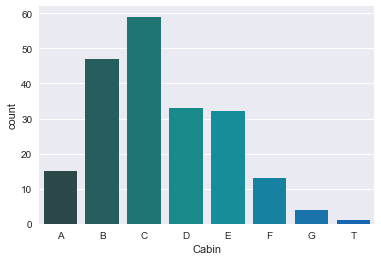

In [23]:
levels = []
for level in deck:
    levels.append(level[0])
cabin_df = DataFrame(levels)
cabin_df.columns = ['Cabin']
sns.countplot('Cabin',data=cabin_df,palette='winter_d',order=sorted(set(levels)))

A,B,C,D,E,F,G... T と T が外れ値となっている（間違ったデータ？？）ので、Tを取り除く。

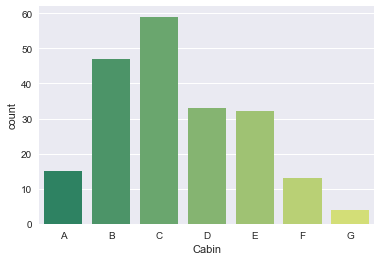

In [24]:
cabin_df = cabin_df[cabin_df.Cabin != 'T']
sns.countplot('Cabin',data=cabin_df,palette='summer',order=sorted(set(cabin_df['Cabin'])))

### 乗客はどこから乗ったか？
Embarkedのカラムを見る。C,Q,S という値は、それぞれCherbourg, Queenstown, Southhampton。Southhamptonが圧倒的におおいことが分かる。

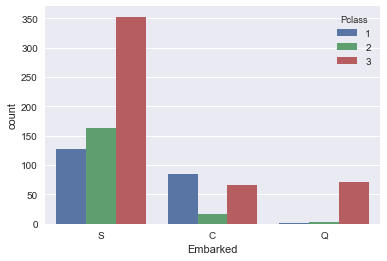

In [25]:
sns.countplot('Embarked',data=titanic_df,hue='Pclass')

In [27]:
titanic_df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

ちなみに自分が小学生のとき、タイタニックの音楽を合奏する機会があって、Southhamptonのマーチをリコーダーで演奏した。

[![IMAGE ALT TEXT HERE](http://img.youtube.com/vi/fCPC6-6n5Uo/0.jpg)](http://www.youtube.com/watch?v=fCPC6-6n5Uo)

## 家族連れか、単身者か？
Aloneのカラムを追加します。

In [30]:
titanic_df['Alone'] = titanic_df.Parch + titanic_df.SibSp
titanic_df['Alone'].loc[titanic_df['Alone'] >0] = 'With Family'
titanic_df['Alone'].loc[titanic_df['Alone'] == 0] = 'Alone'

/home/tsu-nera/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


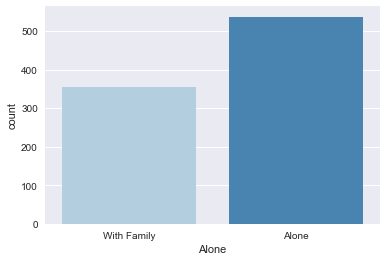

In [31]:
sns.countplot('Alone',data=titanic_df,palette='Blues')

単身者がおおい。

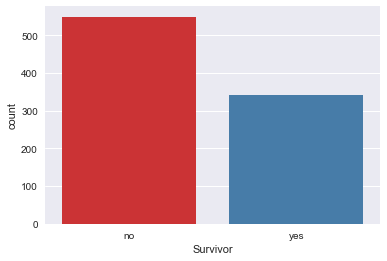

In [32]:
titanic_df["Survivor"] = titanic_df.Survived.map({0: "no", 1: "yes"})
sns.countplot('Survivor',data=titanic_df,palette='Set1')

大勢の人がなくなっていることがわかる。客室の種類は関係があるのかをみると、3等客室が死亡者が多いことがわかる。

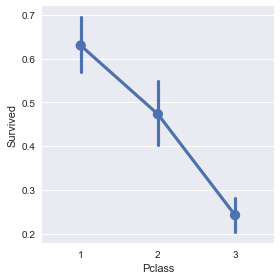

In [33]:
sns.factorplot('Pclass','Survived',data=titanic_df, order=[1,2,3])

「女性と子供を先に」というポリシーが本当に実施されていたかをみる。グラフを見ると、女性や子供の生存率が高い。

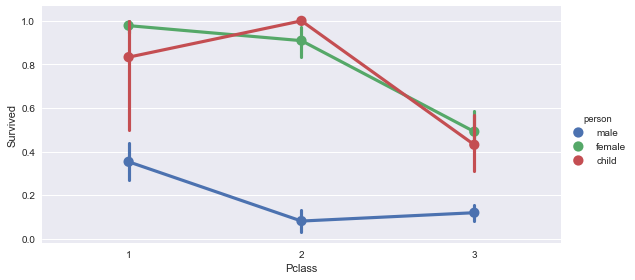

In [34]:
sns.factorplot('Pclass','Survived',hue='person',data=titanic_df, order=[1,2,3], aspect=2)

生存率と年齢の、クラスの関係を見てみると、年齢が高いと生存率が下がる。

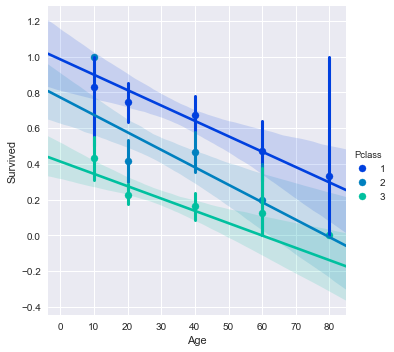

In [36]:
generations=[10,20,40,60,80]
sns.lmplot('Age','Survived',hue='Pclass',data=titanic_df,palette='winter',
           x_bins=generations,hue_order=[1,2,3])

性別と年齢の関係もみる。

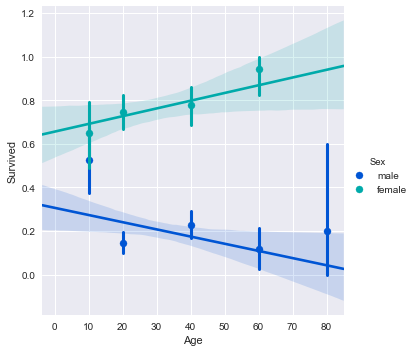

In [37]:
sns.lmplot('Age','Survived',hue='Sex',data=titanic_df,palette='winter',x_bins=generations)

Cabinと生存率の関係もみる。

In [38]:
cabin_df

,Cabin
0,C
1,C
2,E
3,G
4,C
5,D
6,A
7,C
8,B
9,D


## まとめ
* 男性が女性よりも多い。
* 女性や子供は男性よりも生存率が高い。(-> personがfactor候補)
* サウサンプトンからの乗客が多い。
* 高齢者ほど生存率が低い(->Ageがfactor候補）
* クラスが高いほど生存率が高い(-> PClassがfactor候補）
* 単身者が多い